In [1]:
import tweepy
from nltk.tokenize import word_tokenize
import re
import sys
import jsonpickle
import os
import json
from os import path
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk.corpus import stopwords
import string

##Pull in tweets on topic of choice

def tweetPull(topic, follower_count_filter, total):
    
    # Replace the API_KEY and API_SECRET with your application's key and secret.
    API_KEY = 'xxSAJCzdHduRpvNkqxWyFngwL'
    API_SECRET = 'oFaVN1sDSqPqwfcDZ7mdYNZ81KrpokYWvNPsZsesn4CZfB7vcP'

    #AppAuthHandler sets up app only auth for higher limits
    auth = tweepy.AppAuthHandler(API_KEY, API_SECRET)

    #wait_on_rate_limit automatically waits when limit is hit, and continues after
    api = tweepy.API(auth, wait_on_rate_limit=True, 
                     wait_on_rate_limit_notify=True)

    if (not api):
        print ("Can't Authenticate")
        sys.exit(-1)

    file_path = path.relpath("tweetScrapeTest.txt")
    
    searchQuery = topic  # this is what we're searching for
    maxTweets = total # Some arbitrary large number
    tweetsPerQry = 100  # this is the max the API permits
    
    # If results from a specific ID onwards are reqd, set since_id to that ID.
    # else default to no lower limit, go as far back as API allows
    sinceId = None

    # If results only below a specific ID are, set max_id to that ID.
    # else default to no upper limit, start from the most recent tweet matching the search query.
    max_id = -1L

    tweets = []
    tweetCount = 0
    print("Downloading max {0} tweets".format(maxTweets))
    with open(file_path, 'w') as f:
        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry)
                    else:
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break
                for tweet in new_tweets:
                    if tweet._json['user']['followers_count'] > follower_count_filter and tweet._json['lang'] == 'en' and tweet._json['text'][0:2] != 'RT' and tweet._json['in_reply_to_status_id'] == None:
                        tweets.append(tweet._json)
                    #f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                            #'\n')
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id
            except tweepy.TweepError as e:
                # Just exit if any error
                print("some error : " + str(e))
                break
                
    return tweets
    print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, file_path))



In [2]:
def tweets_to_df(list_of_tweets):
    emoticons_str = r"""
        (?:
            [:=;] # Eyes
            [oO\-]? # Nose (optional)
            [D\)\]\(\]/\\OpP] # Mouth
        )"""

    regex_str = [
        emoticons_str,
        r'<[^>]+>', # HTML tags
        r'(?:@[\w_]+)', # @-mentions
        r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
        r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

        r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
        r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
        r'(?:[\w_]+)', # other words
        r'(?:\S)' # anything else
    ]

    tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
    emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

    def tokenize(s):
        return tokens_re.findall(s)

    def preprocess(s, lowercase=False):
        tokens = tokenize(s)
        if lowercase:
            tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
        return tokens
    
    unicodeChars = [u"\u2026",u'\u2013',u'\u2019', u'\ud83d', u'\ude02', u'\u2605',u'\ud83c', u'\xa0']
    punctuation = list(string.punctuation)
    stop = stopwords.words('english') + punctuation + ['rt', 'via', 'bitcoin', 'btc'] + unicodeChars
        
    data = []
    temp = []
    hashes = []

    for item in list_of_tweets:
        cleaned_text_no_stops = []
        cleaned_text = preprocess(item['text'].lower())
        for word in cleaned_text:
            if word not in stop and not word.startswith(('#', '@')):
                cleaned_text_no_stops.append(word)
        pol = TextBlob(item['text']).sentiment.polarity
        
        temp.append(item['created_at'])
        temp.append(item['text'])
        if len(item['entities']['hashtags']) > 0:
            for i in item['entities']['hashtags']:
                hashes.append(i['text'])
        else:
            hashes = ''
        temp.append(hashes)
        temp.append((item['user']['name'], item['user']['screen_name']))
        temp.append(item['user']['followers_count'])
        temp.append(item['favorite_count'])
        temp.append(item['retweet_count'])
        temp.append(pol)
        temp.append(cleaned_text_no_stops)
        data.append(temp)
        temp = []
        hashes = []
    
    df = pd.DataFrame(data, columns=['timestamp','text','hashtags','user','user_followers','favorites','retweets','polarity','tokenized_text'])
    df['timestamp'] = pd.to_datetime(df.timestamp)
    return df
    
    

In [3]:
def polFilter(polaritySeries):
    pols = []
    for row in polaritySeries:
        if abs(row) > .2:
            pols.append(row)
            
    return sum(pols)/len(pols)

In [7]:
def dashboard(df):
    from nltk import bigrams
    from collections import Counter
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline
    
    def polFilter(series):
        pols = []
        for row in series:
            if abs(row) > .2:
                pols.append(row)
        return sum(pols)/len(pols)
    
    pol = polFilter(df.polarity)
    
    all_words = []
    
    for i in range(len(df)):
        all_words = all_words + df.tokenized_text.iloc[i]

    count_all = Counter()
    count_all.update(all_words)
    plotdata = count_all.most_common(5)
    
    print 'highest rated tweet: ' + df.text.iloc[df.favorites.idxmax()]
    print 'user : ' + str(df.user.iloc[df.favorites.idxmax()][1])
    print 'tweet sentiment: ' + str(df.polarity.iloc[df.favorites.idxmax()])
    print plotdata
    print 'Aggregate Sentiment for Subject: ' + str(pol)
    

    # save the names and their respective scores separately
    # reverse the tuples to go from most frequent to least frequent 
    topics = zip(*plotdata)[0]
    mentions = zip(*plotdata)[1]
    x_pos = np.arange(len(topics)) 
    
    polDi

    # calculate slope and intercept for the linear trend line
    slope, intercept = np.polyfit(x_pos, mentions, 1)
   
    plt.bar(x_pos, mentions, align='center')
    plt.xticks(x_pos, topics) 
    plt.xlabel('Common Topics')
    plt.ylabel('# of Mentions')
    plt.show()

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
highest rated tweet: SICK #ISIS militants made female prisoners TORTURE EACH OTHER for not wearing a veil! 
https://t.co/VKVwnNyXfR https://t.co/KQedYeTeqf
user : JoeCostello
tweet sentiment: -0.290178571429
[(u'isis', 129), (u'india', 43), (u'mg', 17), (u'indian', 16), (u'terror', 12)]
Aggregate Sentiment for Subject: 0.211192128949


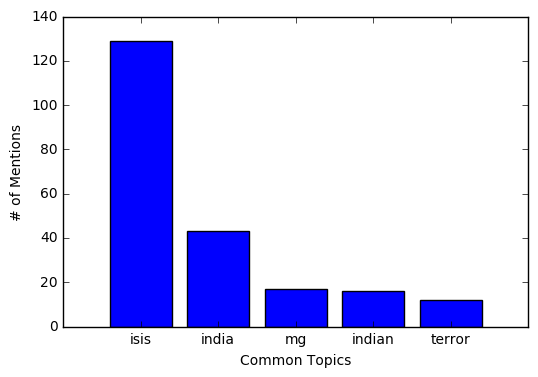

In [11]:
dashboard(tweets_to_df(tweetPull('isis', 100, 1000)))

In [ ]:
df = tweets_to_df(tweetPull('trump',100,5000))

Downloaded 99 tweets
Downloaded 199 tweets
Downloaded 299 tweets
Downloaded 399 tweets
Downloaded 499 tweets
Downloaded 599 tweets
Downloaded 699 tweets
Downloaded 788 tweets
Downloaded 883 tweets
Downloaded 983 tweets
Downloaded 1083 tweets
Downloaded 1181 tweets
Downloaded 1281 tweets
Downloaded 1381 tweets
Downloaded 1481 tweets
Downloaded 1581 tweets
Downloaded 1681 tweets
Downloaded 1781 tweets
Downloaded 1881 tweets
Downloaded 1981 tweets
Downloaded 2081 tweets
Downloaded 2181 tweets
Downloaded 2281 tweets
Downloaded 2381 tweets
Downloaded 2481 tweets
Downloaded 2581 tweets
Downloaded 2681 tweets
Downloaded 2781 tweets
Downloaded 2881 tweets
Downloaded 2981 tweets
Downloaded 3081 tweets
Downloaded 3181 tweets
Downloaded 3281 tweets
Downloaded 3381 tweets
Downloaded 3481 tweets
Downloaded 3581 tweets
Downloaded 3681 tweets
Downloaded 3781 tweets
Downloaded 3881 tweets
Downloaded 3981 tweets
Downloaded 4081 tweets
Downloaded 4181 tweets
Downloaded 4281 tweets
Downloaded 4381 tweets

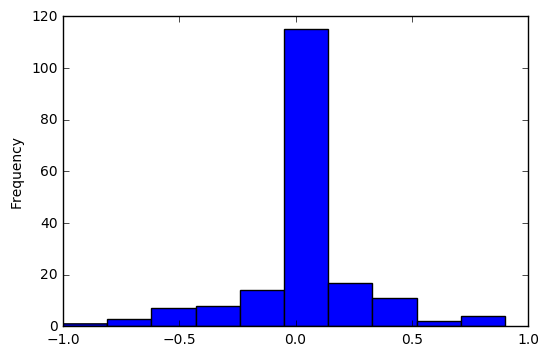

In [13]:
df.polarity.plot(kind='hist')

In [30]:
def polDist(series):
    controversial = []
    for score in series:
        if score < 0:
            adjVal = -1*(abs(score)**.25)
        else:
            adjVal = score**.5
        controversial.append(adjVal)
    controversial = [x for x in controversial if x != 0]
    negative = [x for x in controversial if x < 0]
    positive = [x for x in controversial if x > 0]
    print 'negative tweets: ' + str(len(negative)), 'positive tweets: ' + str(len(positive))
    return pd.Series(controversial).plot(kind='hist')

NameError: name 'controversial' is not defined

negative tweets: 35 positive tweets: 48


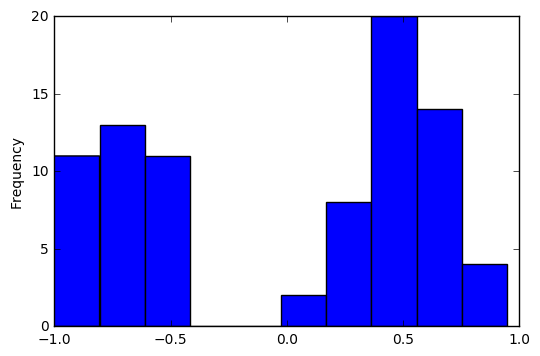

In [31]:
polDist(df.polarity)